# Hi-res model


David Siegel
7:22 AM (3 hours ago)
to me, David, Laure, Eric, Zachary, Andrew

Hi Matt,

As we were discussed at the meeting, we (EXPORTS) would really like to know what the eddy resolving BGC-CESM model says about eddy sign for staging the cruise.  We (kinda) know how to find a retentive feature based upon NRT altimetry. What we don’t know is the BGC response of a cyclone vs. anticyclone would be. We can make arguments either which way, but need some help here (even from a model!!).  Anyways our targets are the inner box (46-52N and 15-23W) for the months April and May (see below). Where we are trying to get at in the center of a cyclone or anticyclone are BGC process (biomass, NPP, NCP, export, etc.) reduced or enhanced during that time of year at that location.  Even a collection of snapshots from the model could be useful.  

Let me know if you need any clarifications in this request…  Thanx in advance, Dave

In [1]:
%matplotlib inline
import os
from subprocess import call
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd
import dask

import cftime
import time

import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import cmocean

import pop_tools

import util

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


## spin up a dask cluster

Matplotlib is not thread safe, so ensure that each task is only one thread.

In [2]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client

def start_cluster(njobs=36):  
    print('starting dask cluster')
    
    cluster = NCARCluster()
    cluster.scale(njobs) #adapt(minimum_jobs=1, maximum_jobs=40)
    client = Client(cluster) # Connect this local process to remote workers
    print(cluster.dashboard_link)
    return client, cluster

## search for files

In [3]:
case = 'g.e11.G.T62_t12.eco.006'
droot = f'/glade/scratch/mclong/hi-res-eco/{case}/ocn/hist'
files = sorted(glob(f'{droot}/{case}.pop.h.????-??-??.nc'))
len(files)

365

In [4]:
grid = pop_tools.get_grid('POP_tx0.1v2')
grid    

<xarray.Dataset>
Dimensions:      (nlat: 2400, nlon: 3600, z_t: 62, z_w: 62, z_w_bot: 62)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05 5.75e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5.5e+05 5.75e+05 6e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -78.47 -78.47 -78.47 ... 62.34 62.34 62.34
    TLONG        (nlat, nlon) float64 250.0 250.2 250.2 ... 250.0 250.0 250.0
    ULAT         (nlat, nlon) float64 -78.45 -78.45 -78.45 ... 62.34 62.34 62.34
    ULONG        (nlat, nlon) float64 -109.9 -109.8 -109.7 ... -110.0 -110.0
    DXT          (nlat, nlon) float64 2.222e+05 2.222e+05 ... 2.042e+03 927.1
    DYT          (nlat, nlon) float64 4.699e+05 4.699e+05 ... 1.664e+03 794.8
    TAREA        (nlat, nlon) float64 1.044e+11 1.044e+11 ... 7.369e+05
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04 2.5e+04
Attributes:
    lateral_dims:       [2400, 3600]
    vertical_dims:      62
    vert_grid_file:     tx0.1v3_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/tx0.1v2/grid/horiz_grid_200709.ieeer8
    topography_fname:   inputdata/ocn/pop/tx0.1v2/grid/topography_km62_201711...
    region_mask_fname:  inputdata/ocn/pop/tx0.1v2/grid/region_mask_20080702.i...
    type:               tripole
    title:              POP_tx0.1v2 grid

## Set the domain

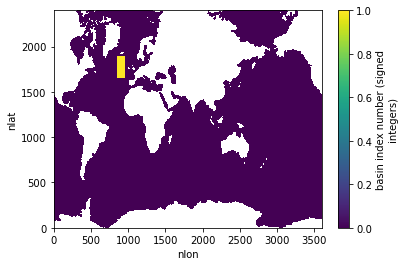

In [5]:
 # 46-52N and 15-23W 
domain = {'lat': [45, 52.5], 
          'lon': [360-24, 360-14]}

J, _ = np.where((domain['lat'][0] <= grid.TLAT) & (grid.TLAT <= domain['lat'][1]))
_, I = np.where((domain['lon'][0] <= grid.TLONG) & (grid.TLONG <= domain['lon'][1]))

inx = slice(I.min(), I.max())
jnx = slice(J.min(), J.max())

mask = xr.full_like(grid.REGION_MASK, fill_value=0).where(grid.KMT > 0)
mask[jnx, inx] = 1 
mask.plot()

## Process model output

In [6]:
nmolcm2s_to_molm2yr = 1e4 * 86400. * 365. * 1e-9

def compute_chl_surf(ds):
    chl = (ds.spChl.isel(z_t_150m=0, drop=True) + 
            ds.diatChl.isel(z_t_150m=0, drop=True) + 
            ds.diazChl.isel(z_t_150m=0, drop=True))
    chl.attrs = {'units': ds.spChl.units, 'long_name': 'Surface Chl'}
    return chl


def compute_ncp_100m(ds):
    ncp = (ds.J_DIC.sel(z_t=slice(0, 100e2)) * ds.dz.sel(z_t=slice(0, 100e2))).sum('z_t')
    ncp = (-1.0) * ncp * nmolcm2s_to_molm2yr
    ncp.attrs = {'units': 'mol m$^{-2}$ yr$^{-1}$', 'long_name': 'NCP (z > -100 m)'}
    return ncp
    
    
def compute_poc_flux_100m(ds):
    poc_flux_100m = ds.POC_FLUX_IN.sel(z_t=100e2, method='nearest', drop=True)
    poc_flux_100m = poc_flux_100m * nmolcm2s_to_molm2yr
    poc_flux_100m.attrs = {'units': 'mol m$^{-2}$ yr$^{-1}$', 'long_name': 'POC flux (100 m)'}
    return poc_flux_100m

derived_vars = {'chl_surf': compute_chl_surf, 
                'NCP': compute_ncp_100m, 
                'POC_flux_100m': compute_poc_flux_100m}

In [7]:
def filename_file_out(file_in, variable):

    basename = os.path.basename(file_in).replace('pop.h', f'pop.h.{variable}')
    datestr = basename.split('.')[-2]    
    basename = basename.replace(f'.{datestr}', '')
    basename = basename.replace('.nc', '.zarr')
    return f'data/{basename}'


def open_dataset_one_timelevel(file_in, variable):   
    
    with xr.open_dataset(file_in, decode_coords=False) as ds:           
        if variable in derived_vars:
            da = derived_vars[variable](ds).isel(nlat=jnx, nlon=inx)
        else:
            da = ds[variable].isel(nlat=jnx, nlon=inx)
        
        dso = xr.Dataset()
        dso[variable] = da.compute()
        for v in dso.variables:
            if '_FillValue' not in dso[v].encoding:
                dso[v].encoding['_FillValue'] = None

        return dso
        

        
client = None        
ds_list_merge = []
for v in ['SSH', 'chl_surf', 'NCP', 'POC_flux_100m']:

    file_out = filename_file_out(files[0], v)        
    
    if not os.path.exists(file_out):

        if client is None:
            client, cluster = start_cluster()
            
        ds_list_concat = []
        
        for f in files:             
            ds_list_concat.append(dask.delayed(open_dataset_one_timelevel)(f, v))

        ds_list_concat = dask.compute(*ds_list_concat)            
        dset = xr.concat(ds_list_concat, dim='time', data_vars='minimal')
        dset.to_zarr(file_out)
        ds_list_merge.append(dset)

    else:
        dset = xr.open_zarr(file_out).compute()
        ds_list_merge.append(dset)
    
ds = xr.merge(ds_list_merge)

if client is not None:        
    client.close()
    cluster.close()
    
ds

<xarray.Dataset>
Dimensions:        (nlat: 241, nlon: 99, time: 365)
Coordinates:
  * time           (time) object 0001-01-06 00:00:00 ... 0006-01-01 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    SSH            (time, nlat, nlon) float32 -29.437681 -30.0975 ... -58.302483
    chl_surf       (time, nlat, nlon) float32 0.13753961 ... 0.00898011
    NCP            (time, nlat, nlon) float32 0.17464347 ... -0.57863224
    POC_flux_100m  (time, nlat, nlon) float32 0.21497501 ... 0.0005374134

Compute the mean SSH field

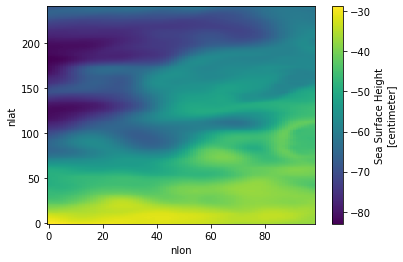

In [8]:
with xr.set_options(keep_attrs=True):
    ssh_mean = ds['SSH'].mean(dim='time')
ssh_mean.plot()

Apply a simple smoothing function to the mean SSH field.

This is crude, but should be ok for initial visualization.

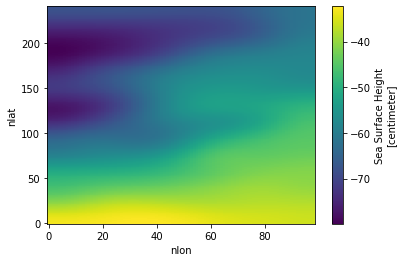

In [9]:
import scipy 
import scipy.ndimage
ssh_mean_smth = xr.full_like(ssh_mean, fill_value=np.nan)
ssh_mean_smth.data = scipy.ndimage.filters.gaussian_filter(ssh_mean.values, [10., 10.], mode='mirror')

ssh_mean_smth.plot()

Compute SSH anomalies

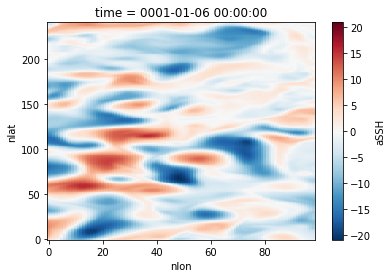

In [10]:
ds['aSSH'] = ds['SSH'] - ssh_mean_smth
ds.aSSH.isel(time=0).plot()

In [11]:
ds.aSSH.values.min(), ds.aSSH.values.max()

(-29.11942, 28.374672)

## Eddy tracks
Tracks were from SLA that was filtered using a loess.  The only issue I had was with edge effects along the domain boundaries.   I have fixed that now and have new tracks for you to use (link below).  

gaube_structured_tracks_reformat.mat?dl=0

The results of any composite analysis should be unchanged unless you are using eddies that propagate across the 0-360 degree boundary.  This problem has been resolved in the version I have attached to this email.  Even if you don’t use eddies in this regions, I suggest you start using these updated tracks.

In [12]:
def date(ymd):
    """Return cftime object corresponding to model time at the end of the averaging interval"""
    num = cftime.date2num(cftime.DatetimeNoLeap(ymd[0], ymd[1], ymd[2]), 
                          units='days since 0001-01-01 00:00:00', calendar='noleap')
    return cftime.num2date(num+1, units='days since 0001-01-01 00:00:00', calendar='noleap')

In [13]:
file_local_tracks = './data/gaube_structured_tracks_reformat.gzip'

if not os.path.exists(file_local_tracks):
    track_file = '/glade/p/cgd/oce/people/mclong/hi-res-eco/data/analysis/gaube_structured_tracks_reformat.mat'
    tracks = util.track_mat2py(track_file)

    in_region = ((domain['lat'][0] <= tracks.y) & (tracks.y <= domain['lat'][1]) & 
                 (domain['lon'][0] <= tracks.x) & (tracks.x <= domain['lon'][1]))

    tracks = tracks.loc[in_region].reset_index()    

    print(f'writing {file_local_tracks}')
    tracks.to_csv(file_local_tracks, compression='gzip', index=True)
    
else:
    print(f'reading {file_local_tracks}')
    tracks = pd.read_csv(file_local_tracks, compression='gzip')
    
tracks['time'] = tracks[['year', 'mon', 'day']].apply(date, axis=1)   
tracks

reading ./data/gaube_structured_tracks_reformat.gzip


,Unnamed: 0,index,x,y,amp,area,u,age,Ls,id,cyc,year,mon,day,time
0,0,77,345.017916,45.243535,5.978040,17506.440855,10.927903,25.0,74.649000,78,1,1,1,5,0001-01-06 00:00:00
1,1,2867,339.191105,51.942869,1.393375,4717.681116,NaN,10.0,38.751575,111351,-1,1,1,10,0001-01-11 00:00:00
2,2,2899,343.879721,49.976579,3.322654,30297.236035,4.546787,20.0,98.203410,111377,-1,1,1,10,0001-01-11 00:00:00
3,3,6893,339.514680,51.943507,1.953841,5745.997173,NaN,10.0,42.766900,111351,-1,1,1,15,0001-01-16 00:00:00
4,4,6925,343.675240,50.293491,4.167441,25875.469585,6.956565,20.0,90.754712,111377,-1,1,1,15,0001-01-16 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4663,4663,1517043,344.439846,47.157490,2.110460,8774.181582,NaN,30.0,52.847978,109325,1,5,12,31,0006-01-01 00:00:00
4664,4664,1518810,338.696344,46.851582,6.506414,44584.650837,11.891233,25.0,119.129069,225872,-1,5,12,31,0006-01-01 00:00:00
4665,4665,1518845,342.642812,45.599949,1.498164,6651.642815,NaN,15.0,46.013951,226572,-1,5,12,31,0006-01-01 00:00:00
4666,4666,1518847,343.117749,49.111349,7.197111,19338.696822,11.816581,170.0,78.458259,216729,-1,5,12,31,0006-01-01 00:00:00


## plotting functions
Define a plot function to be called in loop

In [ ]:
contour_spec = dict(
    chl_surf=dict(levels=np.arange(0, 1.1, 0.1), extend='max'),
    NCP=dict(levels=np.arange(0, 50.5, 5), extend='both'),    
    POC_flux_100m=dict(levels=np.arange(0, 10.5, 0.5), extend='max'),
)

def long_name_units(variable):
    if 'long_name' in ds[variable].attrs:
        long_name = ds[variable].attrs['long_name']
    else:
        long_name = variable

    if 'units' in ds[variable].attrs:
        units = ds[variable].attrs['units']
    else:
        units = None
    
    return long_name, units


lon = grid.TLONG.isel(nlat=jnx, nlon=inx)
lat = grid.TLAT.isel(nlat=jnx, nlon=inx)

def one_plot(da_var, da_aSSH, time_level, time_index, long_name, units, figname=None):
       
    fig = plt.figure(figsize=(16, 8))

    # 46-52N and 15-23W 
    extent = [-24, -15, 45, 53]
    
#    prj = ccrs.Mollweide(central_longitude=np.mean(extent[0:2]))
    prj = ccrs.Mercator(central_longitude=np.mean(extent[0:2]))
    ax = plt.axes(projection=prj)
    ax.set_extent(extent)

    cf = ax.contourf(lon, lat, da_var,                     
                     transform=ccrs.PlateCarree(),
                     **contour_spec[variable])
    
    ax.contour(lon, lat, da_aSSH,               
               colors='gray',
               levels=np.arange(-20, 24, 4),
               transform=ccrs.PlateCarree()); 

    cyclone = tracks.loc[(time_level == tracks.time) & (tracks.cyc == -1)]
    ax.plot(cyclone.x, cyclone.y, 'rx', markersize=6, transform=ccrs.PlateCarree())
    ax.plot(cyclone.x, cyclone.y, 'ro', markersize=8, markerfacecolor='none', transform=ccrs.PlateCarree())
    
    anticyc = tracks.loc[(time_level == tracks.time) & (tracks.cyc == 1)]
    ax.plot(anticyc.x, anticyc.y, 'b.', markersize=4, transform=ccrs.PlateCarree())
    ax.plot(anticyc.x, anticyc.y, 'bo', markersize=8, markerfacecolor='none', transform=ccrs.PlateCarree())    
    
    cb = plt.colorbar(cf)
    
    ax.set_title(f'{time_level.year:04d}-{time_level.month:02d}-{time_level.day:02d}', loc='left')
    ax.set_title(f'{long_name}', loc='right')

    if units is not None:
        cb.ax.set_title(f'{units}')
    
    
    ax.set_yticks(np.arange(45, 55, 2.5), crs=ccrs.PlateCarree())
    ax.set_xticks(np.arange(-24, -14, 2), crs=ccrs.PlateCarree())
    
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    
    if figname is not None:
        fig.savefig(figname, dpi=300, bbox_inches='tight')    
        plt.close()
    
i = 90  
variable = 'POC_flux_100m'

long_name, units = long_name_units(variable)

one_plot(da_var=ds[variable].isel(time=i), 
         da_aSSH=ds['aSSH'].isel(time=i), 
         time_level=ds.time.values[i],
         time_index=i, 
         long_name=long_name, 
         units=units)

## loop over files and plot each

Call `plot` in loop using `dask.delayed`

In [ ]:
results = []
for v in ['NCP', 'POC_flux_100m', 'chl_surf',]:
    
    os.makedirs(f'figs/movie_imgs/{v}', exist_ok=True)
    
    long_name, units = long_name_units(v)
    
    for i in range(len(files)):
        figo = one_plot(da_var=ds[v].isel(time=i), 
                        da_aSSH=ds['aSSH'].isel(time=i), 
                        time_level=ds.time.values[i],
                        time_index=i, 
                        long_name=long_name, 
                        units=units,
                        figname=f'figs/movie_imgs/{v}')
        results.append(figo)
            
#results = dask.compute(*results)         

Call compute to execute plotting